## Tokenization
Basically when we build large language model model the data needs to be pre-processed in a certain manner before it is used for pre-training and in this data pre-processing pipeline the first step is tokenization. At its really basic form tokenization is just the process of breaking down a sentence into individual words. 

## Tokenization Steps
Tokenization can generally be divided into three main steps.
* The first step involves splitting the text into individual words and sub-tokens. Picture having a large block of text and breaking it down into separate words; this constitutes the initial step of tokenization.
* The second step is to convert these tokens into token IDs.
* Finally, the third step is to encode these token IDs into vector representations.

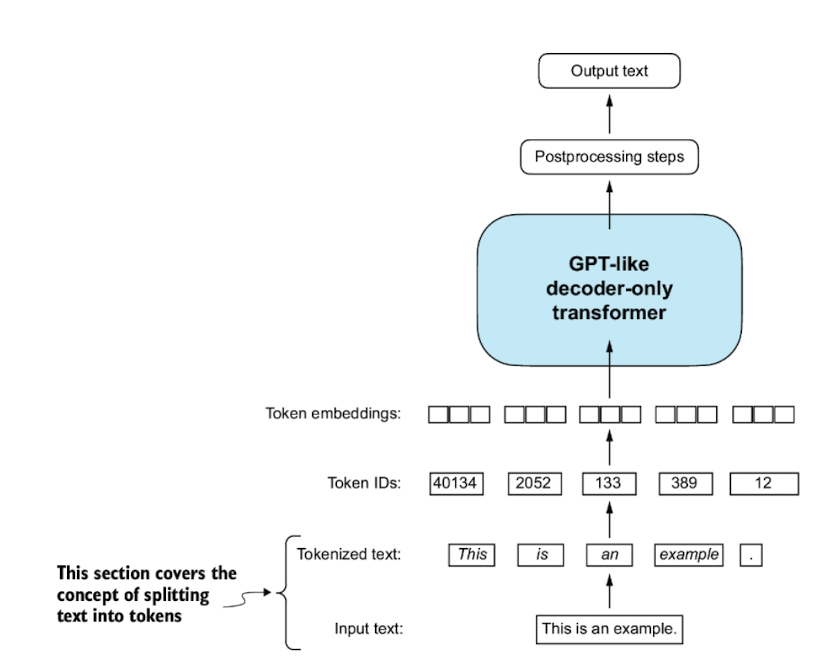

* We will use the book "The Verdict" as input text for building the tokenizer

## Step 1: Creating Tokens

In [22]:
with open("the-verdict.txt", "r", encoding="utf-8") as f:
    raw_text = f.read()
    
print("Total number of character:", len(raw_text))
print(raw_text[:99])

Total number of character: 20782
THE VERDICT
June 1908

I had always thought Jack Gisburn rather a cheap genius--though a

good fell


<div class="alert alert-block alert-success">

Our goal is to tokenize this 20,782-character short story into individual words and special
characters that we can then turn into embeddings for LLM training  </div>

<div class="alert alert-block alert-success">

How can we best split this text to obtain a list of tokens? For this, we use Python's regular expression library re for illustration purposes. 
</div>

In [23]:
#Sample Example split on spaces
import re

text = "Hello, world. This, is a test."
result = re.split(r'(\s)', text)

print(result)

['Hello,', ' ', 'world.', ' ', 'This,', ' ', 'is', ' ', 'a', ' ', 'test.']


<div class="alert alert-block alert-warning">

We want to modify the regular expression splits on whitespaces (\s) and commas, and periods
([,.]):</div>

In [24]:
result = re.split(r'([,.]|\s)', text)

print(result)

['Hello', ',', '', ' ', 'world', '.', '', ' ', 'This', ',', '', ' ', 'is', ' ', 'a', ' ', 'test', '.', '']


<div class="alert alert-block alert-warning">

Whitespace characters remain as tokens and we can remove them. 
</div>

In [25]:
result = [item for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'This', ',', 'is', 'a', 'test', '.']


<div class="alert alert-block alert-success">

Important : REMOVING WHITESPACES OR NOT


When developing a simple tokenizer, whether we should encode whitespaces as
separate characters or just remove them depends on our application and its
requirements. Removing whitespaces reduces the memory and computing
requirements. However, keeping whitespaces can be useful if we train models that
are sensitive to the exact structure of the text (for example, Python code, which is
sensitive to indentation and spacing). Here, we remove whitespaces for simplicity
and brevity of the tokenized outputs. 

</div>

<div class="alert alert-block alert-warning">

The tokenization scheme we devised above works well on the simple sample text. We
modify it a bit further so that it can also handle other types of punctuation, such as
question marks, quotation marks, and the double-dashes we have seen earlier in the first
100 characters of "The Verdict", along with additional special characters: 
</div>

In [26]:
text = "Hello, world. Is this-- a test?"
result = re.split(r'([,.:;?_!"()\']|--|\s)', text)
result = [item.strip() for item in result if item.strip()]
print(result)

['Hello', ',', 'world', '.', 'Is', 'this', '--', 'a', 'test', '?']


<div class="alert alert-block alert-success">

Now that we got a basic tokenizer working, let's apply it to the entire short
story "The Verdct"

</div>

In [27]:
preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', raw_text)
preprocessed = [item.strip() for item in preprocessed if item.strip()]
print(preprocessed[:30])

['THE', 'VERDICT', 'June', '1908', 'I', 'had', 'always', 'thought', 'Jack', 'Gisburn', 'rather', 'a', 'cheap', 'genius', '--', 'though', 'a', 'good', 'fellow', 'enough', '--', 'so', 'it', 'was', 'no', 'great', 'surprise', 'to', 'me', 'to']


In [28]:
print(len(preprocessed))

4667


## Step 2: Creating Token IDs

<div class="alert alert-block alert-warning">

In the previous section, we tokenized short story and assigned it to a
Python variable called preprocessed. Let's now create a list of all unique tokens and sort
them alphabetically to determine the vocabulary size:</div>

In [29]:
all_words = sorted(set(preprocessed))
vocab_size = len(all_words)

print(vocab_size)

1148


In [30]:
vocab = {token:integer for integer,token in enumerate(all_words)}


In [31]:
for i, item in enumerate(vocab.items()):
    print(item)
    if i >= 50:
        break

('!', 0)
('"', 1)
("'", 2)
('(', 3)
(')', 4)
(',', 5)
('--', 6)
('.', 7)
('1908', 8)
(':', 9)
(';', 10)
('?', 11)
('A', 12)
('AM', 13)
('Ah', 14)
('Among', 15)
('And', 16)
('Are', 17)
('Arrt', 18)
('As', 19)
('At', 20)
('Be', 21)
('Begin', 22)
('Burlington', 23)
('But', 24)
('By', 25)
('Carlo', 26)
('Chicago', 27)
('Claude', 28)
('Come', 29)
('Croft', 30)
('Destroyed', 31)
('Devonshire', 32)
('Don', 33)
('Dubarry', 34)
('Emperors', 35)
('End', 36)
('FELT', 37)
('Florence', 38)
('For', 39)
('Gallery', 40)
('Gideon', 41)
('Gisburn', 42)
('Gisburns', 43)
('Grafton', 44)
('Greek', 45)
('Grindle', 46)
('Grindles', 47)
('HAD', 48)
('HAS', 49)
('HAVE', 50)


<div class="alert alert-block alert-info">
As we can see, based on the output above, the dictionary contains individual tokens
associated with unique integer labels. 
</div>

<div class="alert alert-block alert-success">

Later when we want to convert the outputs of an LLM from numbers back into
text, we also need a way to turn token IDs into text. 

For this, we can create an inverse
version of the vocabulary that maps token IDs back to corresponding text tokens.

</div>

<div class="alert alert-block alert-success">

Let's implement a complete tokenizer class in Python.

The class will have an encode method that splits
text into tokens and carries out the string-to-integer mapping to produce token IDs via the
vocabulary. 

In addition, we implement a decode method that carries out the reverse
integer-to-string mapping to convert the token IDs back into text.

</div>

<div class="alert alert-block alert-info">
    
Step 1: Store the vocabulary as a class attribute for access in the encode and decode methods
    
Step 2: Create an inverse vocabulary that maps token IDs back to the original text tokens

Step 3: Process input text into token IDs

Step 4: Convert token IDs back into text

Step 5: Replace spaces before the specified punctuation

</div>


In [32]:
class SimpleTokenizerV1:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = {i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
                                
        preprocessed = [
            item.strip() for item in preprocessed if item.strip()
        ]
        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.?!"()\'])', r'\1', text)
        return text

<div class="alert alert-block alert-success">

Let's instantiate a new tokenizer object from the SimpleTokenizerV1 class and tokenize a
passage from thw short story to try it out in practice:
</div>

In [33]:
tokenizer = SimpleTokenizerV1(vocab)

text = """"It's the last he painted, you know," 
           Mrs. Gisburn said with pardonable pride."""
ids = tokenizer.encode(text)
print(ids)

[1, 62, 2, 868, 1006, 619, 550, 764, 5, 1144, 614, 5, 1, 76, 7, 42, 869, 1126, 772, 812, 7]


<div class="alert alert-block alert-info">
    
The code above prints the following token IDs:
Next, let's see if we can turn these token IDs back into text using the decode method:
</div>

In [34]:
tokenizer.decode(ids)

'" It\' s the last he painted, you know," Mrs. Gisburn said with pardonable pride.'

<div class="alert alert-block alert-info">

In the example above the tokenizing text was based on a snippet from the training set so this sentence which we gave to the encoder was from
the training set so we knew that the words will be in the vocabulary. However what if the sentence which is given is not present in the vocabulary so we have a vocabulary here which is 1148. What if I give a sentence to en code which is not present in the vocabulary so let's try this.
</div>

In [35]:
text = "Hello, do you like tea?"
print(tokenizer.encode(text))

KeyError: 'Hello'

<div class="alert alert-block alert-info">
    
The problem is that the word "Hello" was not used in the The Verdict short story. 

Hence, it
is not contained in the vocabulary. 

This highlights the need to consider large and diverse
training sets to extend the vocabulary when working on LLMs.

</div>

### ADDING SPECIAL CONTEXT TOKENS

We have implemented a simple tokenizer and applied it to a passage from the training set. We will modify this tokenizer to handle unknown
words.
In particular, we will modify the vocabulary and tokenizer we implemented in the previous section and create a new tokenizer SimpleTokenizerV2, to support two new tokens, <|unk|> and <|endoftext|>

<div class="alert alert-block alert-warning">

We can modify the tokenizer to use an <|unk|> token if it
encounters a word that is not part of the vocabulary. 

Furthermore, we add a token between
unrelated texts. 

For example, when training GPT-like LLMs on multiple independent
documents or books, it is common to insert a token before each document or book that
follows a previous text source

</div>


<div class="alert alert-block alert-success">

Let's now modify the vocabulary to include these two special tokens, <unk> and
<|endoftext|>, by adding these to the list of all unique words that we created in the
previous section:
</div>

In [36]:
all_tokens = sorted(list(set(preprocessed)))
all_tokens.extend(["<|endoftext|>", "<|unk|>"])

vocab = {token:integer for integer,token in enumerate(all_tokens)}

In [37]:
len(vocab.items())

1150

<div class="alert alert-block alert-info">
    
Based on the output of the print statement above, the new vocabulary size is 1150 (the
vocabulary size in the previous section was 1148).

</div>

<div class="alert alert-block alert-success">

As an additional quick check, let's print the last 5 entries of the updated vocabulary:
</div>

In [38]:
for i, item in enumerate(list(vocab.items())[-5:]):
    print(item)

('younger', 1145)
('your', 1146)
('yourself', 1147)
('<|endoftext|>', 1148)
('<|unk|>', 1149)


<div class="alert alert-block alert-success">

A simple text tokenizer that handles unknown words will now 

Step 1: Replace unknown words by <|unk|> tokens
    
Step 2: Replace spaces before the specified punctuations

</div>



In [39]:
class SimpleTokenizerV2:
    def __init__(self, vocab):
        self.str_to_int = vocab
        self.int_to_str = { i:s for s,i in vocab.items()}
    
    def encode(self, text):
        preprocessed = re.split(r'([,.:;?_!"()\']|--|\s)', text)
        preprocessed = [item.strip() for item in preprocessed if item.strip()]
        preprocessed = [
            item if item in self.str_to_int 
            else "<|unk|>" for item in preprocessed
        ]

        ids = [self.str_to_int[s] for s in preprocessed]
        return ids
        
    def decode(self, ids):
        text = " ".join([self.int_to_str[i] for i in ids])
        # Replace spaces before the specified punctuations
        text = re.sub(r'\s+([,.:;?!"()\'])', r'\1', text)
        return text

In [40]:
tokenizer = SimpleTokenizerV2(vocab)

text1 = "Hello, do you like tea?"
text2 = "In the sunlit terraces of the palace."

text = " <|endoftext|> ".join((text1, text2))

print(text)

Hello, do you like tea? <|endoftext|> In the sunlit terraces of the palace.


In [41]:
tokenizer.encode(text)

[1149,
 5,
 372,
 1144,
 645,
 993,
 11,
 1148,
 61,
 1006,
 974,
 1002,
 740,
 1006,
 1149,
 7]

In [42]:
tokenizer.decode(tokenizer.encode(text))

'<|unk|>, do you like tea? <|endoftext|> In the sunlit terraces of the <|unk|>.'

<div class="alert alert-block alert-info">
    
Based on comparing the de-tokenized text above with the original input text, we know that
the training dataset, the story The Verdict, did not contain the words
"Hello" and "palace."

</div>

<div class="alert alert-block alert-warning">

Tokenization is an essential step in processing text as input to
LLMs. Depending on the LLM, some researchers also consider additional special tokens such
as the following:

[BOS] (beginning of sequence): This token marks the start of a text. It
signifies to the LLM where a piece of content begins.

[EOS] (end of sequence): This token is positioned at the end of a text,
and is especially useful when concatenating multiple unrelated texts,
similar to <|endoftext|>. For instance, when combining two different
Wikipedia articles or books, the [EOS] token indicates where one article
ends and the next one begins.

[PAD] (padding): When training LLMs with batch sizes larger than one,
the batch might contain texts of varying lengths. To ensure all texts have
the same length, the shorter texts are extended or "padded" using the
[PAD] token, up to the length of the longest text in the batch.

</div>

<div class="alert alert-block alert-warning">

Note that the tokenizer used for GPT models does not need any of these tokens mentioned
above but only uses an <|endoftext|> token for simplicity

</div>

<div class="alert alert-block alert-warning">

the tokenizer used for GPT models also doesn't use an <|unk|> token for outof-vocabulary words. Instead, GPT models use a byte pair encoding tokenizer, which breaks
down words into subword units
</div>

<div class="alert alert-block alert-info">
    
GPT models do not use the unknown token, then how do GPT models deal with words which are not known? They deal with Words which are not known by using the "bite pair encoder". In bite pair encoding every word is not a token. Words themselves are broken down into subwords and then these subwords are the token.
</div>